# Results of benchmarking tests on `nuc6`


In [3]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Markdown, Image

MAX_ROWS = 100
pd.set_option("display.max_rows", MAX_ROWS)

kernels = [
    "generic",
    "lowlatency",
]

order = [
    "baseline",
    "amd_pstate",
    "idle_halt",
    "idle_poll",
    "isolcpus",
    "isolcpus_nohz",
]

executors = [
    "single_threaded_executor",
    "static_single_threaded_executor",
    "events_executor",
    "multi_threaded_executor",
]

result_dict = {}


def read_csv(path, **kwargs):
    return pd.read_csv(path, delim_whitespace=True, **kwargs)


def benchmark_run_to_dict(run_folder):
    latency_all_csv = Path(f"{run_folder.path}/latency_all.txt").read_text()
    latency_subscribers_csv, latency_publishers_csv = (
        latency_all_csv.strip()
        .split("Subscriptions stats:\n")[1]
        .split("\n\nPublishers stats:\n")
    )

    return {
        "type": run_folder.name,
        # "plot": Image(f"{run_folder.path}/plot.png"),
        "resources": read_csv(f"{run_folder.path}/resources.txt", index_col=0),
        "latency_publishers": read_csv(
            io.StringIO(latency_publishers_csv), index_col=0
        ),
        "latency_subscribers": read_csv(
            io.StringIO(latency_subscribers_csv), index_col=0
        ),
        "latency_total": read_csv(
            f"{run_folder.path}/latency_total.txt", index_col=None
        ),
    }


for kernel in kernels:
    for entry in order:
        path = f"./{kernel}/{entry}"
        key = f"{kernel}_{entry}"

        conditions = Markdown(
            f"## **{entry.upper()} {kernel} kernel**\n" + Path(f"{path}/README.md").read_text() + "\n"
            f"`" + Path(f"{path}/cmdline.txt").read_text().strip() + "`\n"
        )

        run_folders = list(filter(lambda entry: entry.is_dir(), os.scandir(path)))
        runs = dict(
            zip(
                map(lambda folder: folder.name, run_folders),
                map(benchmark_run_to_dict, run_folders),
            )
        )

        result_dict[key] = {
            "name": entry,
            "kernel": kernel,
            "conditions": conditions,
            "runs": runs,
        }

In [4]:
def runs_by_kernel_type(kernel):
    runs = {}

    filtered_result_items = filter(lambda item: item[1].get("kernel") is kernel, result_dict.items())
    for name, result in filtered_result_items:
        runs[name] = result.get("runs")
        
    return runs

def runs_by_executor_type(executor):
    runs = {}

    for name, result in result_dict.items():
        matching_runs = [
            run
            for run_type, run in result.get("runs").items()
            if f"bitbots_{executor}" in run_type
        ]
        if len(matching_runs) == 1:
            runs[name] = matching_runs[0]
        else:
            raise Exception("Found more than one run")

    return runs


runs_by_kernel = {}
runs_by_executor = {}

for kernel in kernels:
    runs_by_kernel[kernel] = runs_by_kernel_type(kernel)

for executor in executors:
    runs_by_executor[executor] = runs_by_executor_type(executor)

/tmp/ipykernel_727500/1920684537.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


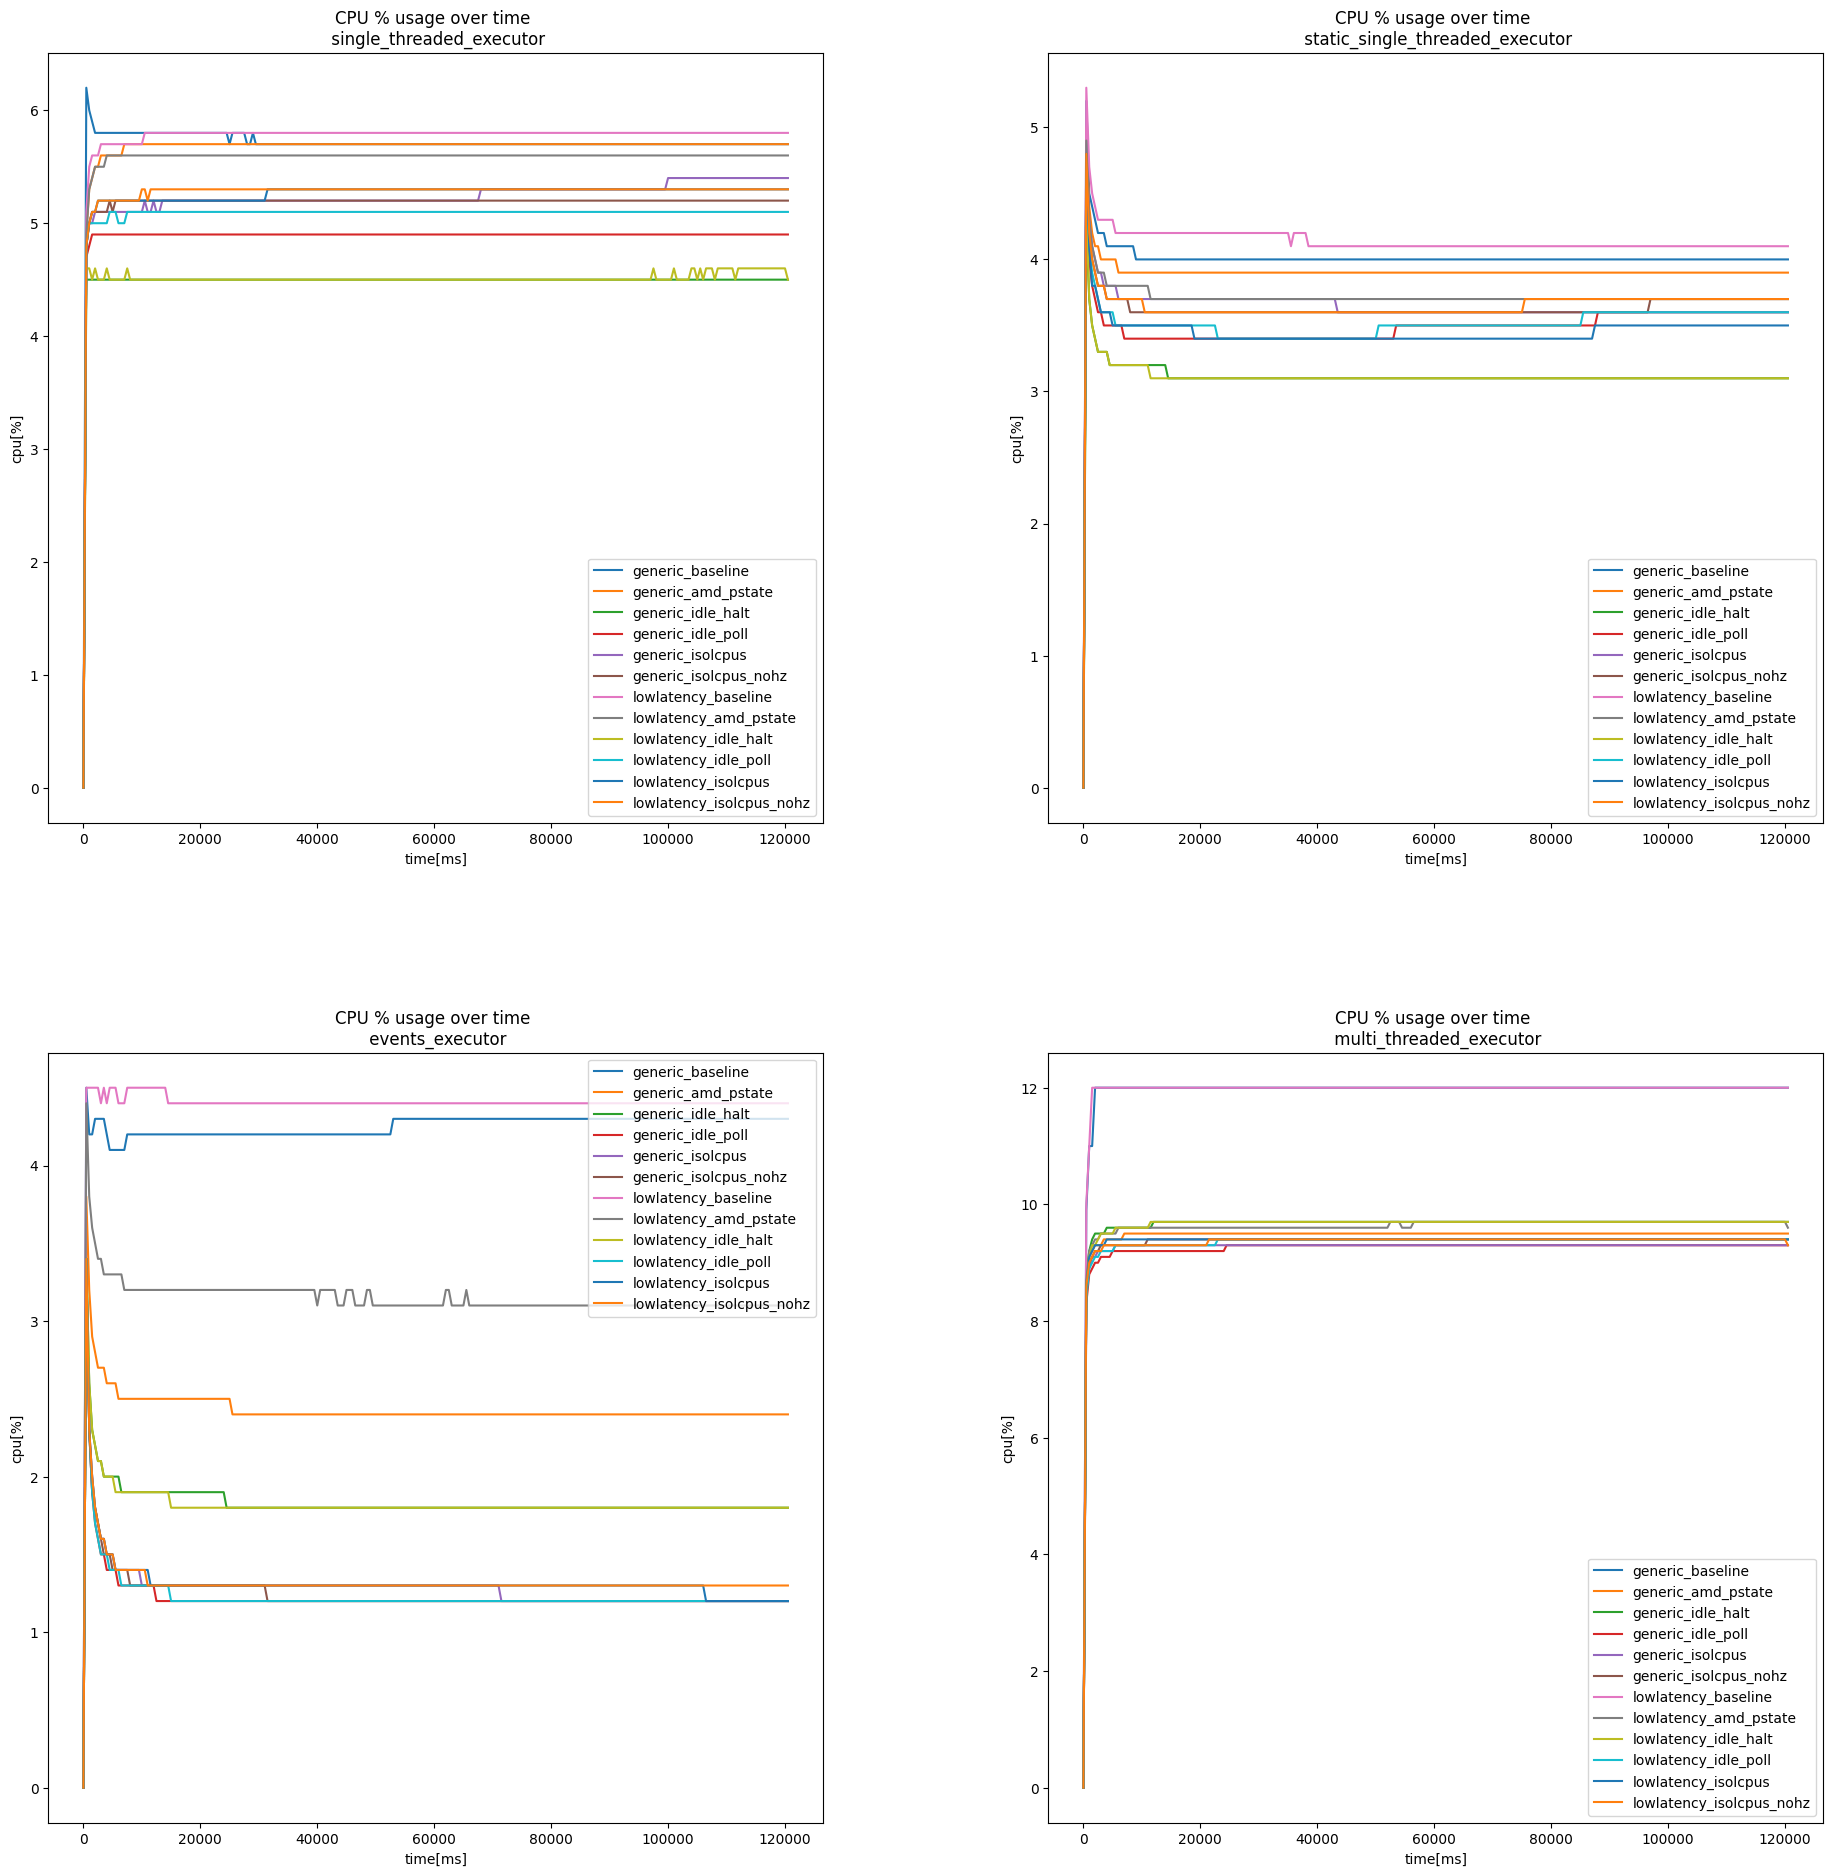

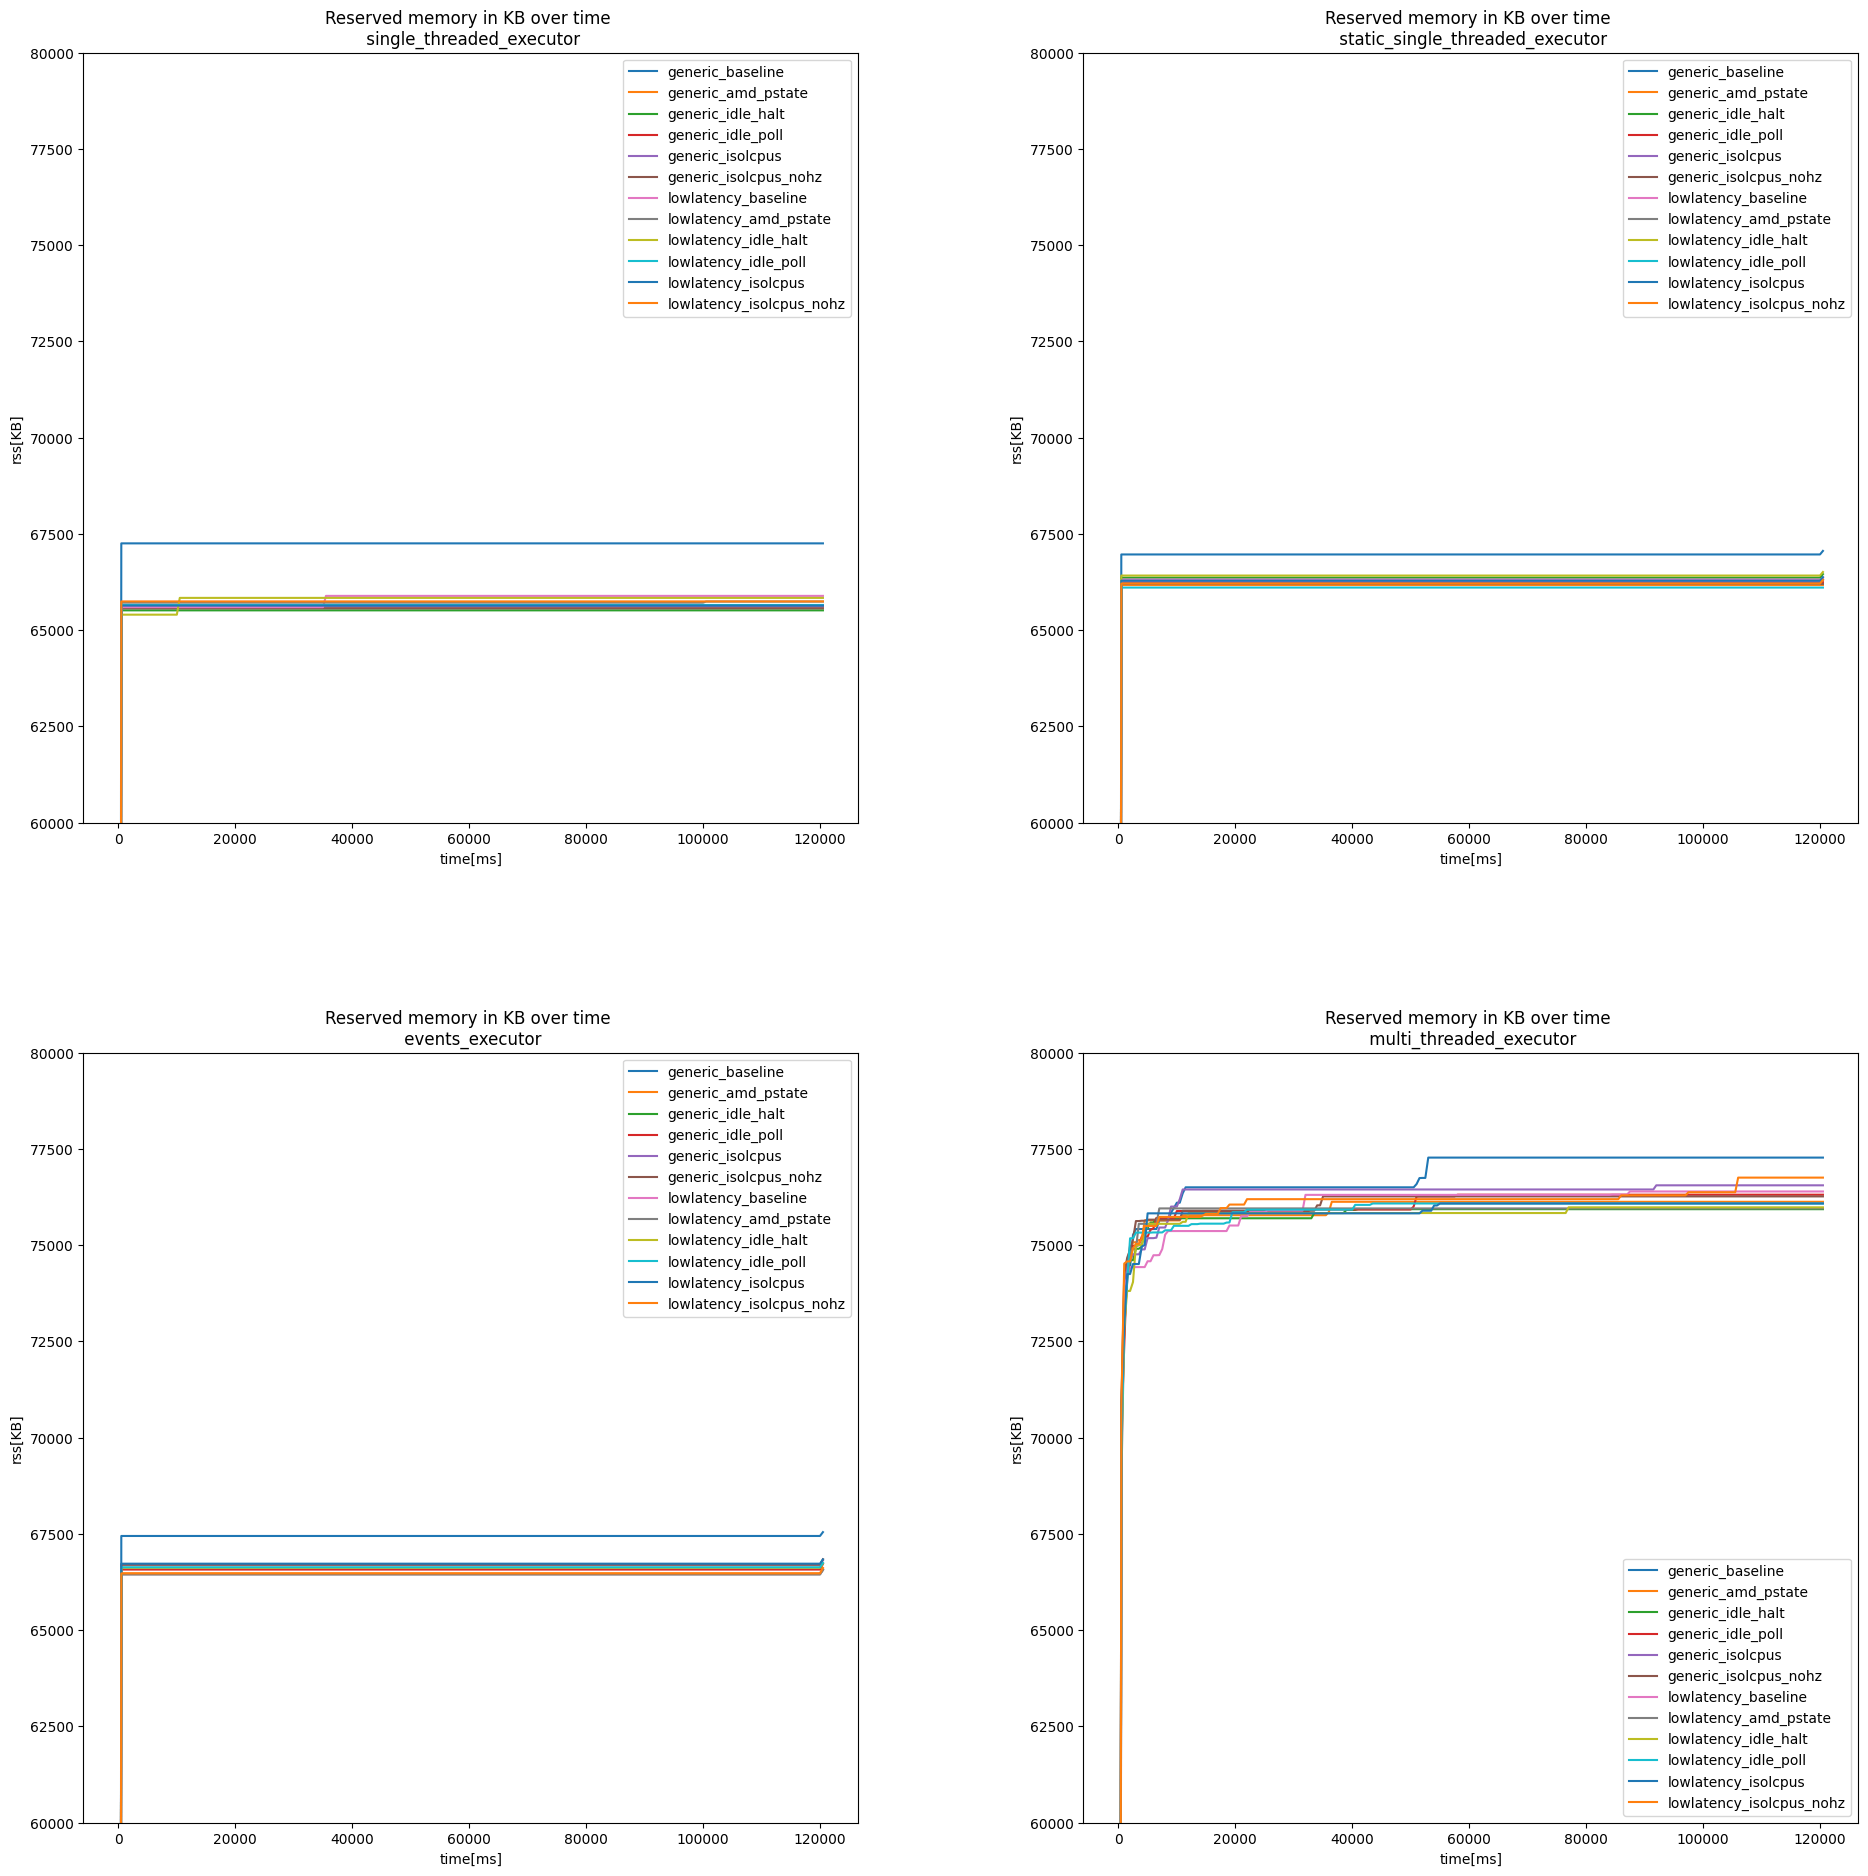

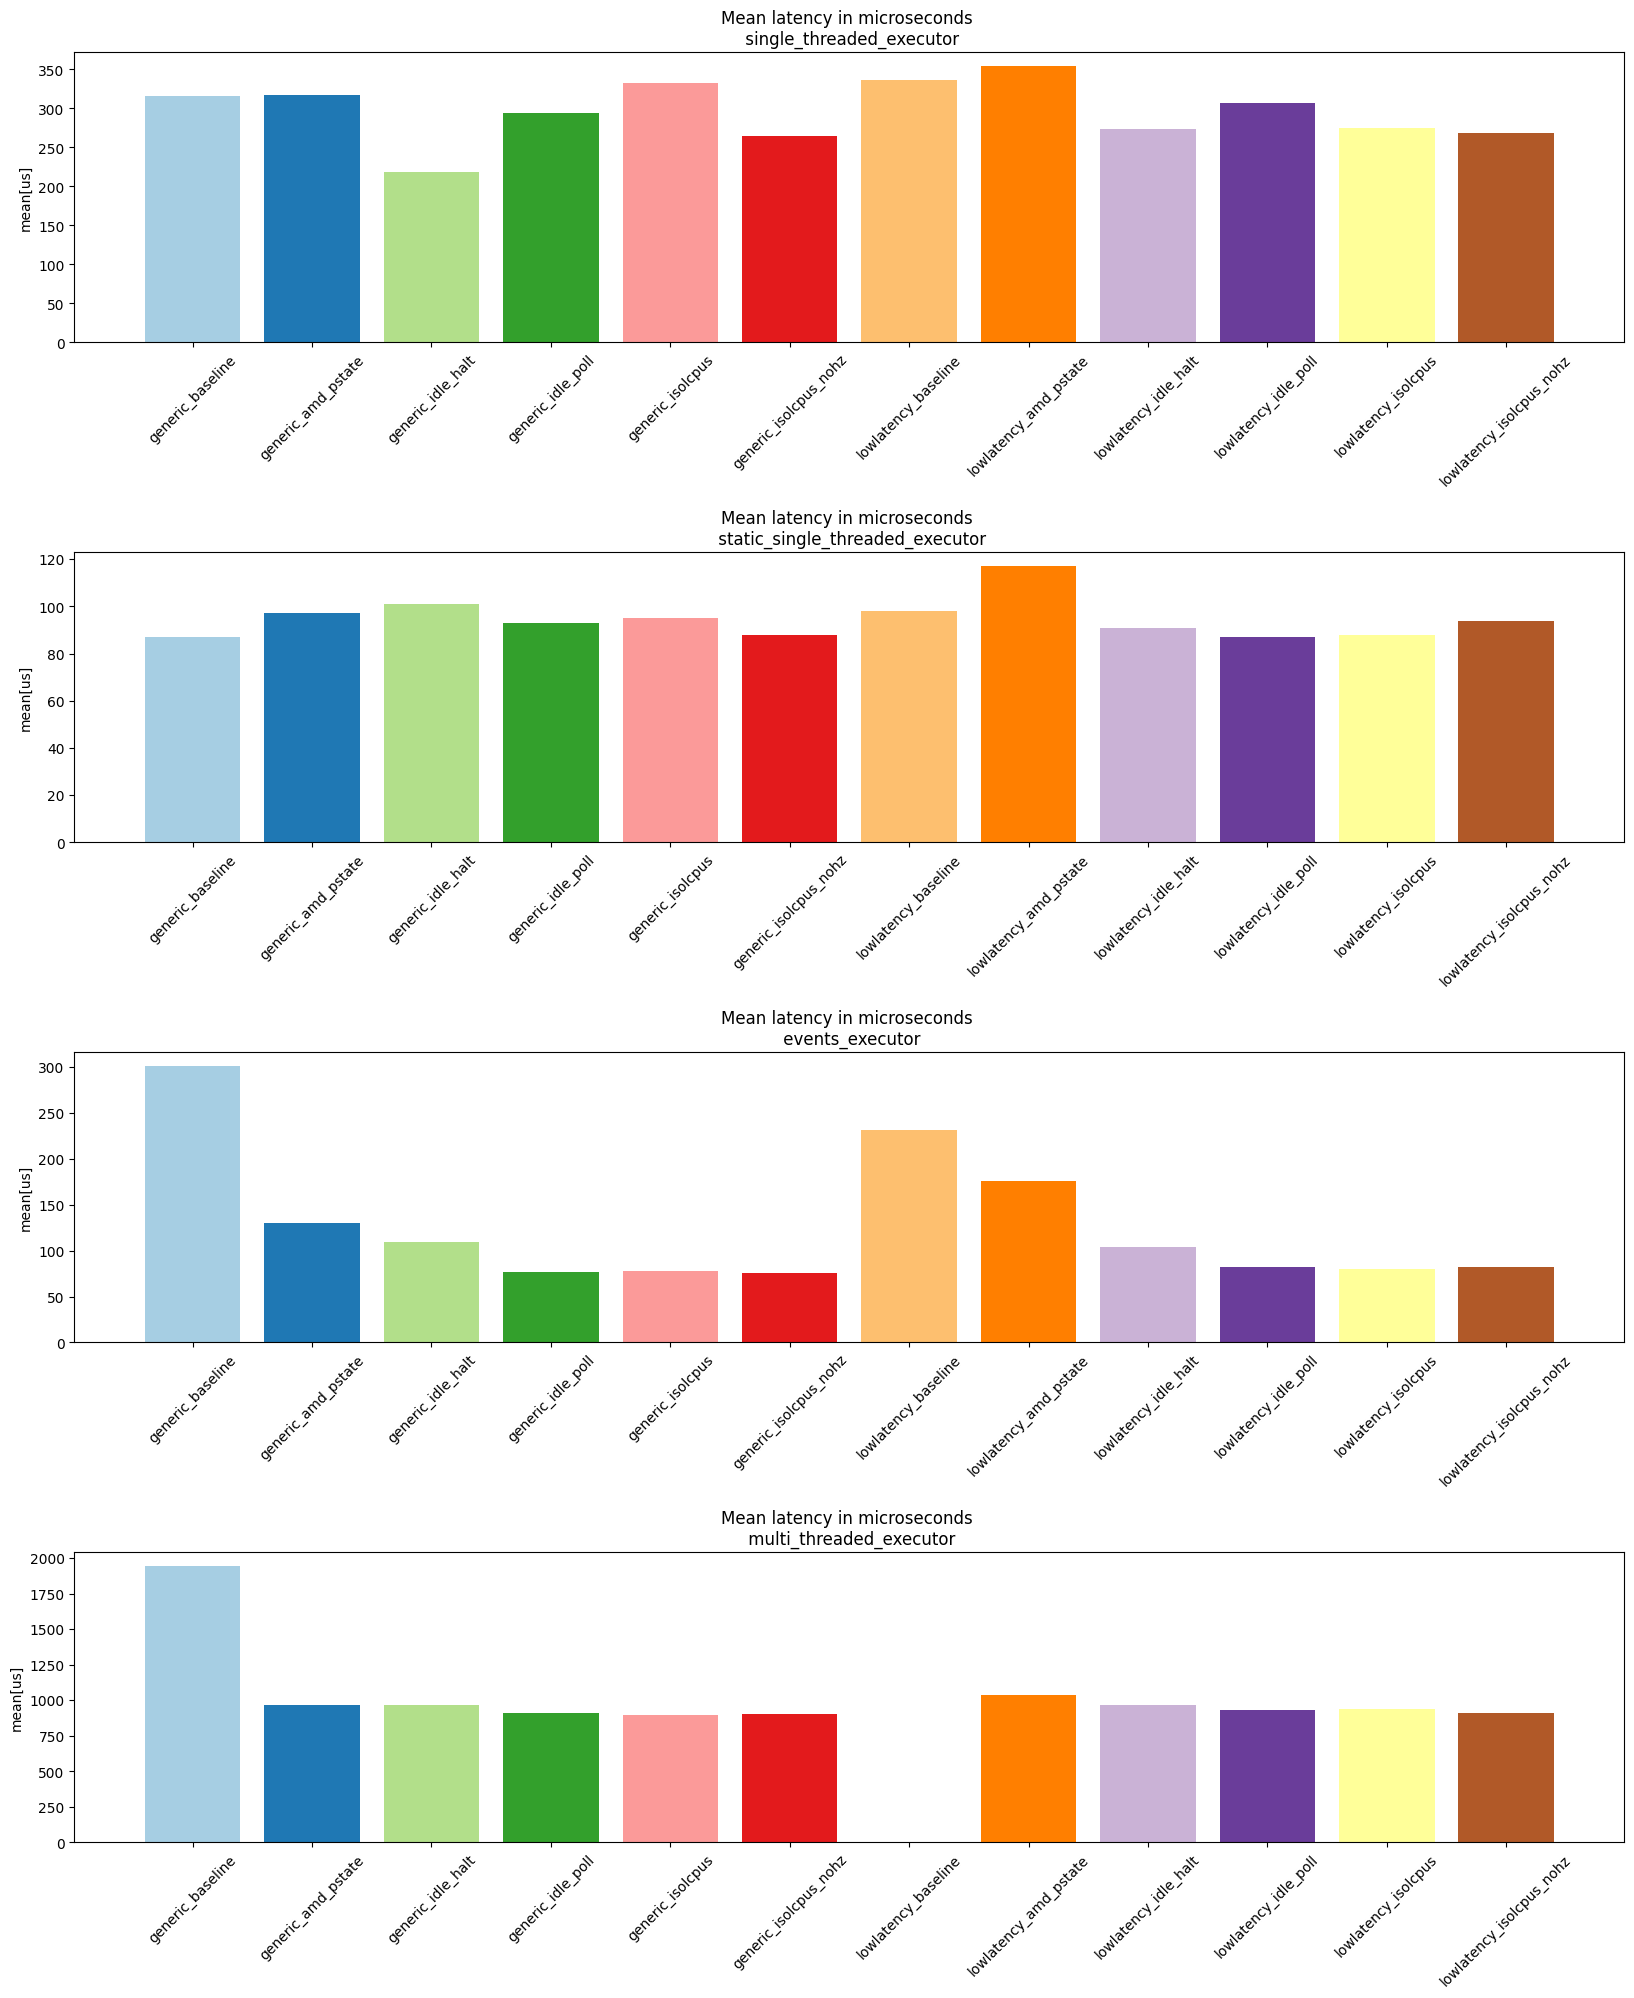

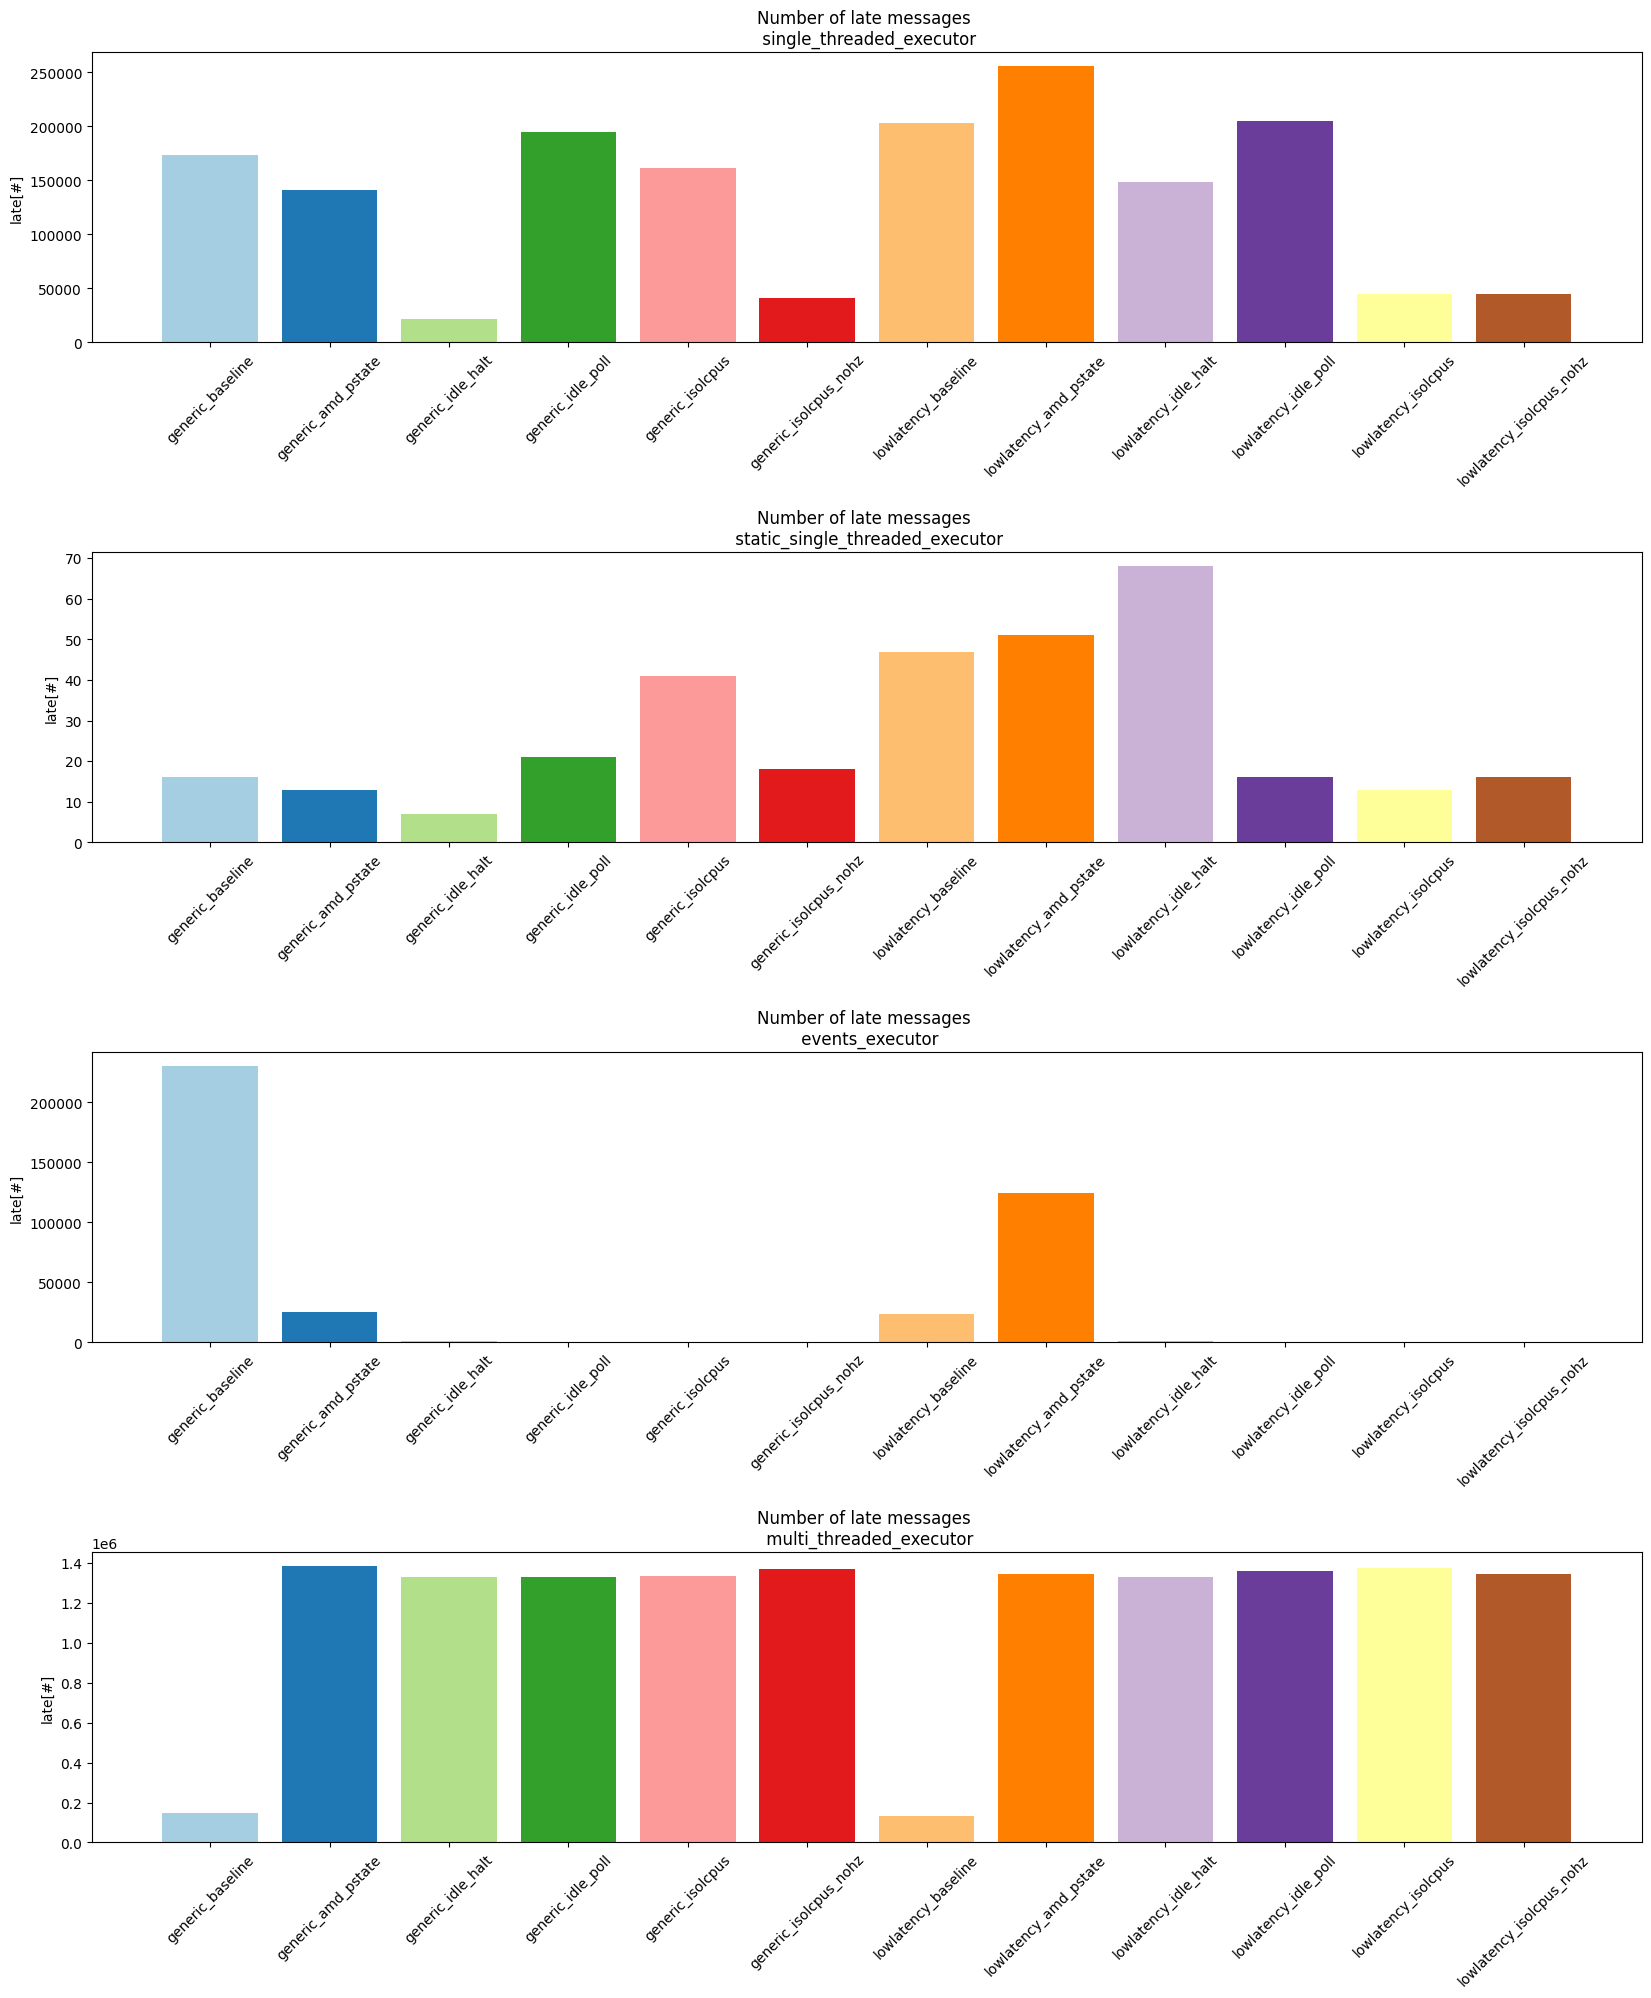

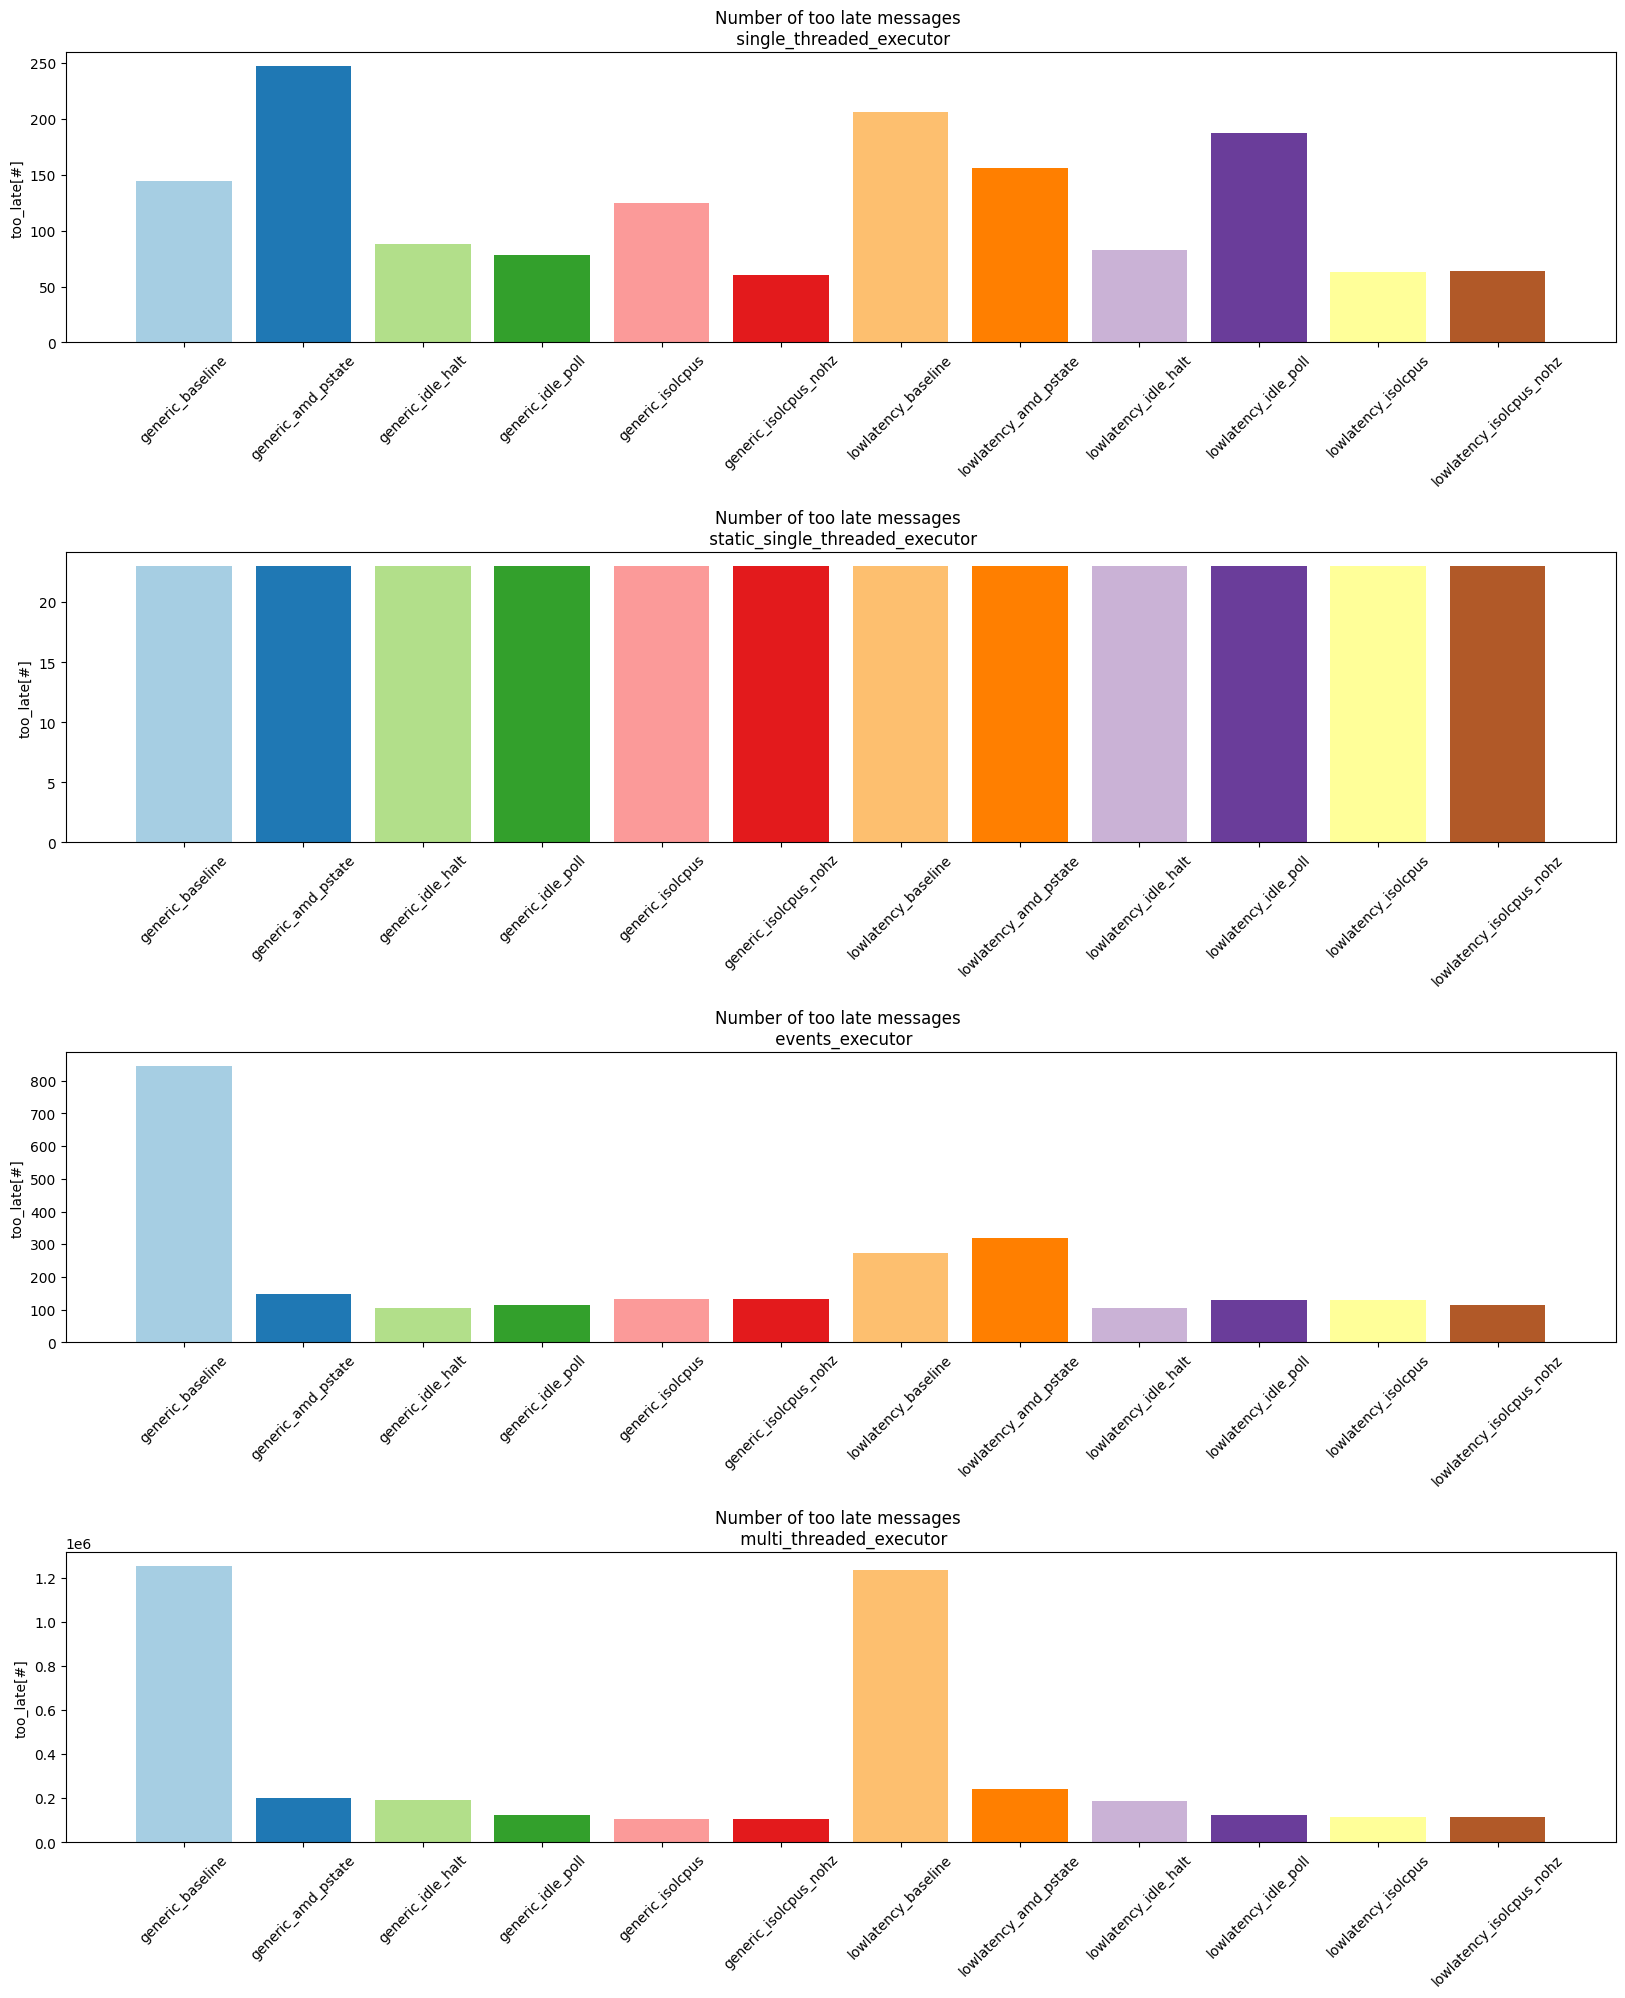

In [5]:
def setup_subplots(config, plt_fn, layout):
    fig = plt.figure(figsize=layout.get("figsize"))
    if layout.get("adjust_subplots", False):
        fig.subplots_adjust(bottom=0.3)
    sub_figs = fig.subfigures(*layout.get("subfigures"))

    for index, sub_fig in enumerate(sub_figs.flat):
        executor, runs = list(runs_by_executor.items())[index]
        ax = sub_fig.subplots()
        ax.set_title(f"{config.get('title')} \n {executor}")
        ax.set_ylabel(config.get("y"))

        if "ylim" in config:
            ax.set_ylim(config.get("ylim"))

        plt_fn(ax, runs)


def plot_benchmark_line_graph(type, config=dict):
    def plt_fn(ax, runs):
        for configuration, run in runs.items():
            run.get(type).plot(
                ax=ax,
                y=config.get("y"),
                label=configuration,
            )

    setup_subplots(config, plt_fn, {"figsize": (20, 20), "subfigures": (2, 2)})


def plot_benchmark_bar_graph(type, config=dict):
    def plt_fn(ax, runs):
        labels = list(runs.keys())
        property = config.get("y")
        df_values = [run.get(type)[property] for run in runs.values()]
        values = np.array(df_values).flatten()
        ax.bar(labels, values, color=plt.cm.Paired(range(len(values))))
        ax.set_xticklabels(labels, rotation=45)

    setup_subplots(
        config,
        plt_fn,
        {"figsize": (20, 20), "subfigures": (4, 1), "adjust_subplots": True},
    )


plt_config = {
    "resources": {
        "kind": "line",
        "graphs": [
            {"title": "CPU % usage over time", "y": "cpu[%]"},
            {
                "title": "Reserved memory in KB over time",
                "y": "rss[KB]",
                "ylim": (60000, 80000),
            },
        ],
    },
    "latency_total": {
        "kind": "bar",
        "graphs": [
            {"title": "Mean latency in microseconds", "y": "mean[us]"},
            {
                "title": "Number of late messages",
                "y": "late[#]",
            },
            {"title": "Number of too late messages", "y": "too_late[#]"},
        ],
    },
}


# for result in result_dict.values():
#     display(result.get("conditions"))

# display(Markdown("## Comparisons of latency and resources"))

# string = ""
# for result in result_dict.values():
#     string += f"{result.get('conditions').data}\n"
# print(string)

for plt_type, config in plt_config.items():
    kind = config.get("kind")
    for conf in config.get("graphs"):
        if kind == "bar":
            plot_benchmark_bar_graph(plt_type, conf)
        else:
            plot_benchmark_line_graph(plt_type, conf)